**Task: tạo một công cụ dự đoán nên bán chiếc xe cũ của mình với giá bao nhiêu so với những thứ khác trên thị trường**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install eli5

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
import plotly.express as px
import plotly.graph_objects as go

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import RandomizedSearchCV


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



In [4]:
merc = pd.read_csv('/content/drive/MyDrive/Datasets/car/merc.csv')
audi = pd.read_csv('/content/drive/MyDrive/Datasets/car/audi.csv')
hyundai = pd.read_csv('/content/drive/MyDrive/Datasets/car/hyundi.csv')


In [5]:
merc['brand'] = 'mercedes'
audi['brand'] = 'audi'
hyundai['brand'] = 'hyundai'

In [6]:
# tax columns của hyundai bị sai nên đổi lại
hyundai.rename(columns={'tax(£)' : 'tax'},inplace=True)

In [7]:
df = pd.concat([merc, audi, hyundai])
df.reset_index(inplace=True, drop=True)
df.shape

(28647, 10)

#1. Xem mô tả dữ liệu

In [8]:
df['mpg'].max()

256.8

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28647 entries, 0 to 28646
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         28647 non-null  object 
 1   year          28647 non-null  int64  
 2   price         28647 non-null  int64  
 3   transmission  28647 non-null  object 
 4   mileage       28647 non-null  int64  
 5   fuelType      28647 non-null  object 
 6   tax           28647 non-null  int64  
 7   mpg           28647 non-null  float64
 8   engineSize    28647 non-null  float64
 9   brand         28647 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 2.2+ MB


Dữ liệu có 10 cột và 28647 dòng

### **Data Description**:
- model : Mẫu xe 
- year : năm đăng ký xe
- price: giá xe cũ bằng Euro
- transmission : loại hộp số ('Automatic', 'Manual', 'Semi-Auto', 'Other' )
- mileage : số dặm đã đi(1 dặm ~ 1.61km)
- fuelType : loại nhiên liệu
- tax : thuế của xe
- mpg : số dặm trên mỗi galong
> 1 gallon ~ 4.5 lít xăng/dầu
- engineSize : kích thước động cơ (tính bằng lít)
- brand: Hãng xe (Merc, Hyundai, audi)

In [10]:
df.describe()

year          price  ...           mpg    engineSize
count  28647.000000   28647.000000  ...  28647.000000  28647.000000
mean    2017.191434   22000.501484  ...     53.297281      1.914989
std        2.156566   11814.012475  ...     14.143866      0.599529
min     1970.000000     650.000000  ...      1.100000      0.000000
25%     2016.000000   14498.000000  ...     44.100000      1.500000
50%     2017.000000   19890.000000  ...     53.300000      2.000000
75%     2019.000000   26980.000000  ...     61.400000      2.100000
max     2020.000000  159999.000000  ...    256.800000      6.300000

[8 rows x 6 columns]

In [11]:
df.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
brand           0
dtype: int64

#2. Datasets Processing

In [12]:
# Xử lý tên các model
df['model'] = df.model.apply(lambda x: x.lower()).apply(lambda x: x.strip())

In [13]:
def box_plot(df, colname):
  plt.figure(figsize = (10, 5))
  sns.boxplot(data=df, x=colname)
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



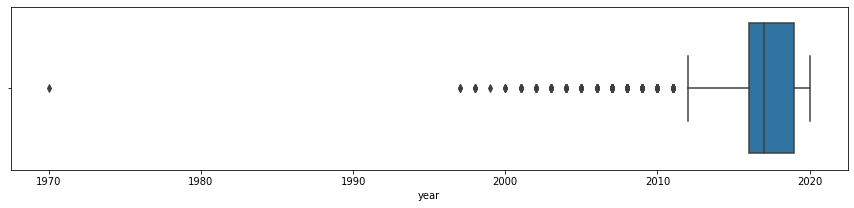

In [14]:
plt.figure(figsize = (15, 3))
sns.boxplot(df['year'])

# plt.grid(True)
plt.show()

In [15]:
df.drop(df[df['year'] == 1970].index, inplace=True)
df.reset_index(inplace=True, drop=True)

In [16]:
# df[df['year'] == 1970]

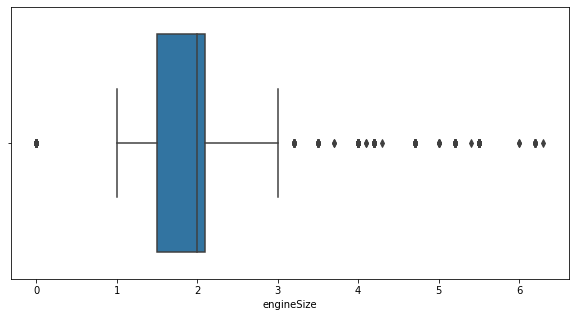

In [17]:
#engineSize
box_plot(df, 'engineSize')

In [18]:
df[df['engineSize']== 0].shape

(115, 10)

##1.4. Columns mpg: Số dặm đi được trên mỗi gallon

**Note:** 
- 1 gallon ~ 4.5 lít xăng/dầu
- 1 dặm ~ 1.61km 

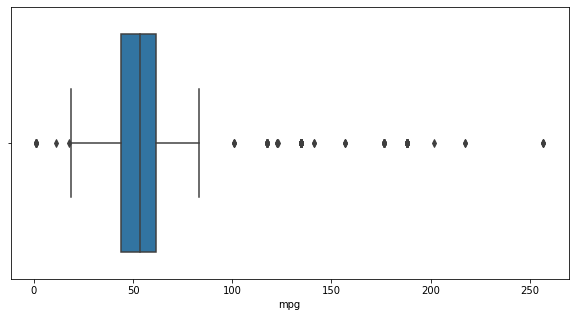

In [19]:
box_plot(df, 'mpg')

In [20]:
df['mpg'].describe()

count    28646.000000
mean        53.297773
std         14.143868
min          1.100000
25%         44.100000
50%         53.300000
75%         61.400000
max        256.800000
Name: mpg, dtype: float64

In [21]:
df[df['mpg'] >= 200]

model  year  price transmission  ...  tax    mpg  engineSize     brand
6205   c class  2019  34890    Semi-Auto  ...  135  217.3         2.0  mercedes
11419  e class  2019  34995    Automatic  ...  140  201.8         2.0  mercedes
12893  c class  2020  40999    Automatic  ...  135  217.3         2.0  mercedes
24999    ioniq  2018  18970    Automatic  ...  135  256.8         1.6   hyundai
25874    ioniq  2019  19995    Automatic  ...  135  256.8         1.6   hyundai
26001    ioniq  2018  18999    Automatic  ...  135  256.8         1.6   hyundai

[6 rows x 10 columns]

#Đề xuất điền dữ liệu

In [22]:
backup_engineSize = df['engineSize'].copy()
backup_engineSize

0        1.8
1        2.1
2        5.5
3        4.0
4        4.0
        ... 
28641    1.6
28642    1.7
28643    1.0
28644    1.6
28645    1.7
Name: engineSize, Length: 28646, dtype: float64

In [23]:
size = df[['brand', 'transmission', 'engineSize']]

In [24]:
lb_encoder = LabelEncoder()

size['brand'] = lb_encoder.fit_transform(size['brand'])
size = pd.concat(
    [size['brand'], pd.get_dummies(size['transmission']), size['engineSize']], axis=1)

size_khac_0 = size[size['engineSize'] != 0]
size_0 = size[size['engineSize'] == 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
size_khac_0.head()

brand  Automatic  Manual  Other  Semi-Auto  engineSize
0      2          1       0      0          0         1.8
1      2          1       0      0          0         2.1
2      2          1       0      0          0         5.5
3      2          1       0      0          0         4.0
4      2          1       0      0          0         4.0

In [26]:
size_0.head()

brand  Automatic  Manual  Other  Semi-Auto  engineSize
9618      2          1       0      0          0         0.0
9619      2          1       0      0          0         0.0
9621      2          1       0      0          0         0.0
9650      2          0       0      1          0         0.0
9654      2          1       0      0          0         0.0

In [27]:
size_0.drop('engineSize', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
X = size_khac_0.copy()
y = X.pop('engineSize')

In [29]:
model = RandomForestRegressor()
model.fit(X, y)

size_pred = model.predict(size_0)

In [30]:
size_pred

array([2.16738043, 2.16738043, 2.16738043, 2.09862508, 2.16738043,
       2.16738043, 2.16738043, 1.72165634, 2.16738043, 2.16738043,
       2.16738043, 2.21913723, 2.21913723, 1.64117724, 2.21913723,
       2.21913723, 2.21913723, 2.21913723, 1.64117724, 2.21913723,
       1.64117724, 2.21913723, 1.64117724, 2.21913723, 2.21913723,
       2.21913723, 2.21913723, 1.64117724, 2.21913723, 1.64117724,
       2.21913723, 2.21913723, 2.21913723, 2.21913723, 2.21913723,
       2.21913723, 1.64117724, 2.21913723, 1.64117724, 2.21913723,
       2.21913723, 2.21913723, 2.21913723, 2.21913723, 1.64117724,
       2.21913723, 2.21913723, 1.64117724, 2.21913723, 2.21913723,
       2.21913723, 2.21913723, 2.21913723, 1.64117724, 2.21913723,
       2.21913723, 1.64117724, 2.21913723, 2.21913723, 1.64117724,
       1.64117724, 1.64117724, 2.21913723, 1.64117724, 2.21913723,
       1.64117724, 2.21913723, 1.64117724, 1.72821922, 1.72821922,
       1.72821922, 1.72821922, 1.38597294, 1.38597294, 1.38597

In [31]:
size_0['engineSize'] = size_pred.round(1)
size_0.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



brand  Automatic  Manual  Other  Semi-Auto  engineSize
9618      2          1       0      0          0         2.2
9619      2          1       0      0          0         2.2
9621      2          1       0      0          0         2.2
9650      2          0       0      1          0         2.1
9654      2          1       0      0          0         2.2

In [32]:
df.loc[df['engineSize'] == 0, 'engineSize'] = size_0['engineSize']

In [33]:
df.corr()

year     price   mileage       tax       mpg  engineSize
year        1.000000  0.524274 -0.760894  0.083300 -0.189945   -0.070086
price       0.524274  1.000000 -0.481632  0.301217 -0.440646    0.618451
mileage    -0.760894 -0.481632  1.000000 -0.168223  0.258341    0.074279
tax         0.083300  0.301217 -0.168223  1.000000 -0.537490    0.348525
mpg        -0.189945 -0.440646  0.258341 -0.537490  1.000000   -0.306764
engineSize -0.070086  0.618451  0.074279  0.348525 -0.306764    1.000000

#Khám Phá Dữ Liệu (EDA)

## **Questions**:

1. hãng xe nào có trung bình giá bán cao nhất
2. fuelType ảnh hưởng đến price như thế nào ?
3. Mẫu xe nào được bán ra nhiều nhất?
4. transmission và price
5. Sự biến động giá xe sau mỗi năm
6. Số dặm xe đi được trên mỗi galon có ảnh hưởng như thế nào đến giá xe? (có phải mpg càng lớn thì giá càng thấp không?)
7. có phải xe có kích thước động cơ càng lớn thì  giá càng cao không?
8. số dặm xe đã đi có ảnh hưởng gì đến giá xe?
9. Những yếu tố nào khiến cho thuế của 1 chiếc xe lại tăng cao?





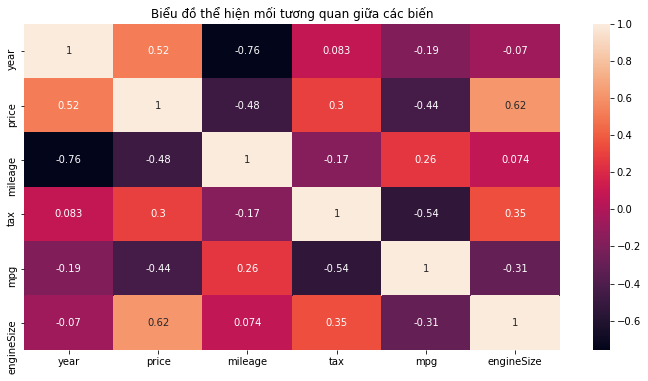

In [34]:
plt.figure(figsize = (12, 6))
plt.title("Biểu đồ thể hiện mối tương quan giữa các biến")
sns.heatmap(df.corr(), annot=True)
plt.show()

### 1.Hãng xe nào có giá bán cao nhất

In [35]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

In [36]:
df_brand = df['price'].groupby(df['brand']).mean().round(2).reset_index()
df_brand

brand     price
0      audi  22896.69
1   hyundai  12750.13
2  mercedes  24698.57

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



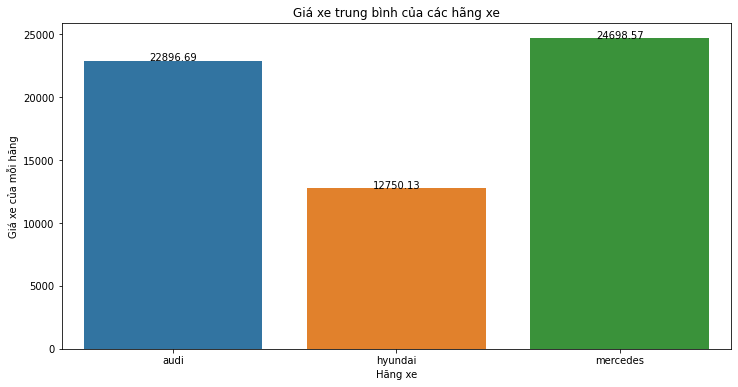

In [37]:
plt.figure(figsize=(12, 6))
plt.title("Giá xe trung bình của các hãng xe")
sns.barplot(df_brand['brand'], df_brand['price'])
addlabels(df_brand['brand'], df_brand['price'])
plt.xlabel("Hãng xe")
plt.ylabel("Giá xe của mỗi hãng")
plt.show()

> **Nhận xét:**
- Mercedes có price maximum **lớn nhất** trong ba brand
- Hyundai là hãng có giá phổ thông **thấp nhất**
- Audi và Mercedes có giá bán gần như **ngang ngửa nhau**

### 2.fuelType ảnh hưởng đến price như thế nào ?

In [38]:
# Vẽ chart
fig = go.Figure(data=go.Scatter(x=df['fuelType'],
                                y=df['price'],
                                mode='markers',
                                marker_color=df['price']
                                )) # hover text goes here

fig.update_layout(title='fuelType and Price')
fig.show()

In [39]:
ful_count = pd.DataFrame(df['fuelType'].value_counts()).reset_index().rename(columns = {"fuelType":"count", "index":"fuelType"})
fig = px.pie(ful_count, values='count', names='fuelType')
fig.show()

In [40]:
ful_count

fuelType  count
0   Diesel  16371
1   Petrol  11717
2   Hybrid    550
3    Other      8

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



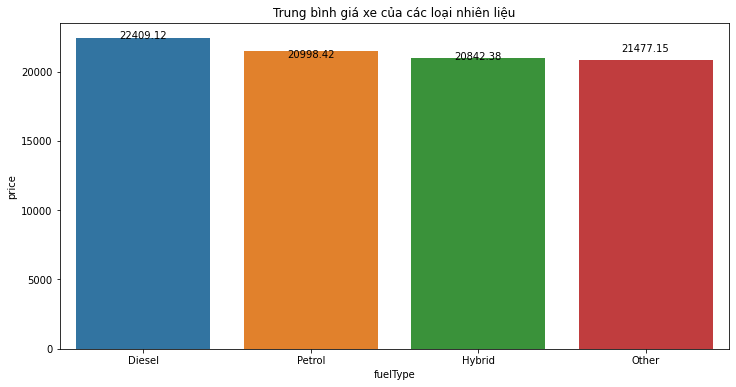

In [41]:
df_fuelType = df['price'].groupby(df['fuelType']).mean().round(2).reset_index().sort_values(by = 'price', ascending = False)
plt.figure(figsize=(12, 6))
plt.title("Trung bình giá xe của các loại nhiên liệu")
sns.barplot(df_fuelType['fuelType'], df_fuelType['price'])
addlabels(df_fuelType['fuelType'], df_fuelType['price'])
plt.show()

**Nhận xét:** *Giá xe của các loại nhiêu liệu là tương đối nganh nhau.*

### 3.Các mẫu xe được bán ra nhiều nhất

In [42]:
df['model'].unique()

array(['slk', 's class', 'sl class', 'g class', 'gle class', 'gla class',
       'a class', 'b class', 'glc class', 'c class', 'e class',
       'gl class', 'cls class', 'clc class', 'cla class', 'v class',
       'm class', 'cl class', 'gls class', 'glb class', 'x-class', '180',
       'clk', 'r class', '230', '220', '200', 'a1', 'a6', 'a4', 'a3',
       'q3', 'q5', 'a5', 's4', 'q2', 'a7', 'tt', 'q7', 'rs6', 'rs3', 'a8',
       'q8', 'rs4', 'rs5', 'r8', 'sq5', 's8', 'sq7', 's3', 's5', 'a2',
       'rs7', 'i20', 'tucson', 'i10', 'ix35', 'i30', 'i40', 'ioniq',
       'kona', 'veloster', 'i800', 'ix20', 'santa fe', 'accent',
       'terracan', 'getz', 'amica'], dtype=object)

**Nhận xét:** *Khi xem unique của mẫu xe mình thấy có các giá trị: 180, 230, 220, 200. thì mình k xác định được nó là dòng C180, E180,... hay gì. Nên mình đề xuất: Bỏ :v. Tại vì nó cũng chỉ có 1 dòng dữ liệu thôi*

In [43]:
df[(df['model'] == "180") | (df['model'] == "200") | (df['model'] == "220") | (df['model'] == "230")]

model  year  price transmission  ...  tax   mpg  engineSize     brand
10463   180  2014  10799       Manual  ...   20  72.4         1.5  mercedes
11347   230  2007   4500    Automatic  ...  520  29.4         2.2  mercedes
11995   220  2018  19995    Automatic  ...  145  61.4         2.0  mercedes
11996   200  2018  19495       Manual  ...  145  64.2         2.2  mercedes

[4 rows x 10 columns]

In [44]:
df.drop(df[(df['model'] == "180") | (df['model'] == "200") | (df['model'] == "220") | (df['model'] == "230")].index, inplace = True)
df.reset_index(inplace=True, drop=True)


In [45]:
df.groupby('price').mean()

year   mileage    tax    mpg  engineSize
price                                             
650     2003.0  109090.0  235.0  40.00         1.4
1200    2002.0   94000.0  325.0  30.40         2.4
1295    2003.5   68900.0  137.5  45.05         1.2
1350    2010.0  116126.0  145.0  54.30         2.0
1395    2008.0  138000.0  125.0  57.60         1.6
...        ...       ...    ...    ...         ...
140319  2019.0     785.0  150.0  22.10         4.0
145000  2020.0    2000.0  145.0  21.10         5.2
149948  2011.0    3000.0  570.0  21.40         6.2
154998  2020.0    3000.0  150.0  21.40         4.0
159999  2020.0    1350.0  145.0  21.40         4.0

[7025 rows x 5 columns]

In [46]:
model_count = pd.DataFrame(df['model'].value_counts().reset_index().rename(columns={"index":"model", "model":"count"})).sort_values(by = 'model')
model_count['price'] =  pd.DataFrame(df['price'].groupby(df['model']).mean().round(2)).reset_index().sort_values(by = 'model')['price']
model_count.sort_values(by='count', ascending=False, inplace=True)

In [47]:
fig = px.bar(model_count[:10], x="model", y="count", title="Top 10 mức độ phố biến của các dòng xe đã mua", hover_name='price')
fig.show()

In [48]:

model_count.sort_values(by = 'price', ascending=False, inplace=True)
fig = px.bar(model_count[:10], x="model", y="price", title="Top 10 giá cao bán cao nhất của các dòng xe đã mua", hover_name='count')
fig.show()

###4.Transmission và price

In [49]:
# Xem sự phân bố của các loại Hộp số

fig = px.histogram(df, x = 'transmission', title='Distribution of transmission', color='brand')
fig.show()

In [50]:
data = df[['transmission', 'price']] 

In [51]:
data = df['price'].groupby(df['transmission']).mean().round(2).reset_index()
data

transmission     price
0    Automatic  25008.36
1       Manual  14067.95
2        Other  15296.25
3    Semi-Auto  26551.29

In [52]:
# Chiết tách 
auto = df[df['transmission'] == 'Automatic']
manual = df[df['transmission'] == 'Manual']
semi = df[df['transmission'] == 'Semi-Auto']

fig = go.Figure()

def _addTrace(df, name):
  fig.add_trace(go.Box(
      y= df['price'],
      name=name,
      boxpoints=False,
      marker_color='darkblue',
      boxmean=True # represent mean
  ))

_addTrace(auto, 'Automatic')
_addTrace(semi, 'Semi-auto')
_addTrace(manual, 'Manual')

fig.show()

**Note**: Loại Semi-Auto và Automatic có giá xe trung bình cao nhất. 

In [53]:
df.transmission.value_counts()

Semi-Auto    11017
Manual        9422
Automatic     8199
Other            4
Name: transmission, dtype: int64

> **Nhận xét**: Giá tiền (mean price) của xe sử dụng loại hộp số (transmission) Tự động đắt hơn loại thủ công ( nghe có vẻ hiển nhiên :)) ). Càng hiện đại thì giá càng đắt.
1. Bộ hộp số càng Hiện đại thì giá trị của xe càng cao, bất kể hãng nào. 
2. Độ Hiện đại giảm dần lần lượt Auto (Hộp số tự động), Semi-Auto(Hộp số bán tự dộng), Muanal(Hộp số thủ công).
3. Năm đăng ký xe của Data trên trung bình là 2016-2017 và Tần suất xuất hiện (Count) của các loại hộp số không quá chênh lệch nên có thể đánh giá khách quan.**Loại Tranmission Càng hiện đại thì giá tiền càng cao.**

###5.Sự biến động giá xe sau mỗi năm? Có phải xe càng cổ thì giá xe càng cao không?

In [54]:
me_year = df[df['brand'] == 'mercedes'].groupby('year').mean().reset_index()
audi_year = df[df['brand'] == 'audi'].groupby('year').mean().reset_index()
hyundai_year = df[df['brand'] == 'hyundai'].groupby('year').mean().reset_index()


In [55]:
df[df['year'] < 2001]

model  year  price transmission  ...  tax   mpg  engineSize     brand
11762       slk  1998   1990    Automatic  ...  265  32.1         2.3  mercedes
11763       slk  2000   1490    Automatic  ...  265  27.2         3.2  mercedes
11789       slk  2000   3990    Automatic  ...  270  27.2         3.2  mercedes
11792   s class  1998  19990    Automatic  ...  265  23.3         6.0  mercedes
11806       slk  1998   1990    Automatic  ...  265  32.1         2.3  mercedes
11858  sl class  1998  10450    Automatic  ...  255  28.2         3.2  mercedes
11910  sl class  1997   9995    Automatic  ...  255  28.2         3.2  mercedes
12007   s class  1999   5995    Automatic  ...  145  24.6         3.2  mercedes
13031  sl class  2000  11750    Automatic  ...  270  24.6         3.2  mercedes
22902        a3  1998   4999    Automatic  ...  265  30.4         1.8      audi
23541        a8  1997   4650    Automatic  ...  265  18.9         4.2      audi
28091    accent  2000   1295    Automatic  ...  150  38.7         1.3   hyundai

[12 rows x 10 columns]

In [56]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=me_year.year, y=me_year.price,
                    mode='lines+markers',
                    name='mercedes'))
fig.add_trace(go.Scatter(x=audi_year.year, y=audi_year.price,
                    mode='lines+markers',
                    name='Audi'))
fig.add_trace(go.Scatter(x=hyundai_year.year, y=hyundai_year.price,
                    mode='lines+markers',
                    name='Hyundai_year'))

fig.show()

**Nhận xét:** *Nhìn chung, trung bình giá bán của các hãng xe tăng dần theo năm. Bộ data chi có từ năm 1997 đến 2020 cho nên không thể coi những chiếc xe đó là xe cổ được*

###6.Số dặm xe đi được trên mỗi galon có ảnh hưởng như thế nào đến giá xe? (có phải mpg càng lớn thì giá càng thấp không?)

In [57]:
# px.scatter()
px.histogram(x = df.mpg, y = df.price, title = 'Sự phân phối của mpg')

**Nhẫn xét:** *mpg tập trung chủ yếu trong phạm vi từ 20 - 150*

In [58]:
df.drop(df[df['mpg'] > 100].index, inplace = True)
df.reset_index(inplace = True, drop = True)

In [59]:
me_mpg = df[df['brand'] == 'mercedes']
audi_mpg = df[df['brand'] == 'audi']
hyundai_mpg = df[df['brand'] == 'hyundai']

In [60]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=me_mpg.mpg, y=me_mpg.price,
                    mode='markers',
                    name='mercedes'))
fig.add_trace(go.Scatter(x=audi_mpg.mpg, y=audi_mpg.price,
                    mode='markers',
                    name='Audi'))
fig.add_trace(go.Scatter(x=hyundai_mpg.mpg, y=hyundai_mpg.price,
                    mode='markers',
                    name='Hyundai'))

fig.show()

**Nhận xét:** *Đúng là số dặm đã đi càng lớn thì giá xe càng thấp.Đối với Mercedes và Audi, giá xe cao nhất khi mpg tập trung trong khoảng từ 20-40, còn Hyndai giá xe cao nhất khi mpg nằm trong khoảng từ 25-60*

###7.Có phải xe có kích thước động cơ càng lớn thì giá càng cao không?

In [61]:
data = df[['engineSize', 'price']] # tách riêng data EngineSize và Price vào 1 bộ
data.head()

engineSize  price
0         1.8   5200
1         2.1  34948
2         5.5  49948
3         4.0  61948
4         4.0  73948

In [62]:
# xem qua engineSize đã qua fill
backup = backup_engineSize
Current = data.engineSize

fig = go.Figure()
fig.add_trace(go.Box(y=backup, name='Backup EngineSize'))
fig.add_trace(go.Box(y=Current, name='Current EngineSize'))
fig.update_traces( boxpoints='suspectedoutliers', jitter = 0)
fig.show()

> **note:** Như đã thấy thuật toán điền dữ liệu cho kết quả rất tốt, khi không làm thay đổi cấu trúc dữ liệu hay các outliers khác của engineSize. engineSize = 0 được điền hợp lý vào các cụm dữ liệu. 

In [63]:
# correlation EngineSize vs Price
print("Correlation: {}".format(data['engineSize'].corr(data['price'])))

Correlation: 0.6195787906600597


> Corr (~0.5) cho thấy có mối tương quan dương nhưng ở mức độ thấp. Nói cách khác có thể chúng đồng biến nhưng không ổn định

In [64]:

fig = go.Figure(data=go.Scatter(x=df['engineSize'],
                                y=df['price'],
                                mode='markers',
                                marker_color=df['price'],
                                text=df['brand'])) # hover text goes here
fig.show()

**Nhận xét:**
1. Nhìn chung có vẻ engineSize tăng thì giá cũng có thể sẽ tăng nhưng không ổn định. 
> VD: Mặc dù engineSize = 6 nhưng giá tiền vẫn thấp
2. Các giá trị còn khá hỗn loạn do có nhiều hãng xe lẫn vào nhau, nên tách ra để rõ hơn.

In [65]:
# Tách dữ liệu các hãng xe để xem rõ hơn
audi = df[df['brand']=='audi']
hyundai = df[df['brand'] == 'hyundai']
merc = df[df['brand'] == 'mercedes']

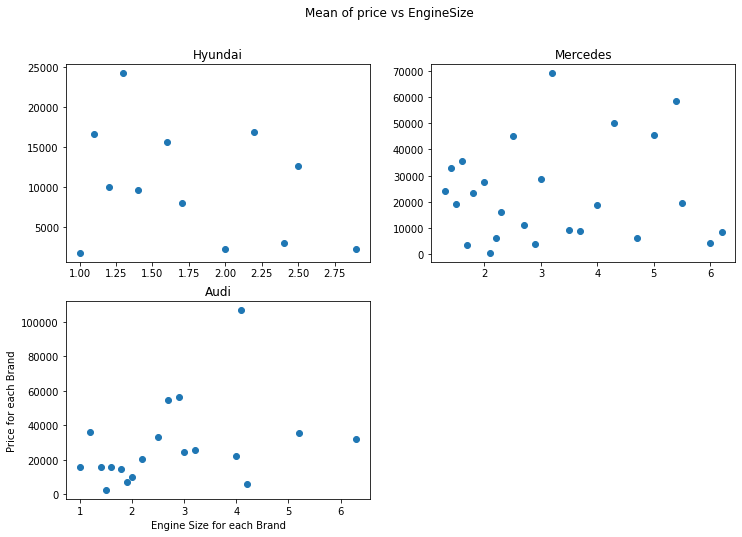

In [66]:
def _getMeanOfGroupEngineSize(df):
  new = df.groupby('engineSize')['price'].mean()
  return new

# Lý do lấy mean: Các giá trị của Price phân tán trên mỗi giá trị engineSize
#VD: 1 engineSize có rất nhiều giá khác nhau thậm chí cả Min lẫn Max

fig, axs = plt.subplots(2,2,figsize=(12,8))
fig.suptitle('Mean of price vs EngineSize')

axs[0, 0].scatter( x = hyundai.engineSize.unique(), y = _getMeanOfGroupEngineSize(hyundai))
axs[0, 1].scatter( x = merc.engineSize.unique(), y = _getMeanOfGroupEngineSize(merc))
axs[1, 0].scatter( x = audi.engineSize.unique(), y = _getMeanOfGroupEngineSize(audi))
fig.delaxes(axs[1][1])

#set title axs
axs[0, 0].set_title('Hyundai') 
axs[0, 1].set_title('Mercedes') 
axs[1, 0].set_title('Audi') 


#set labels for axs
plt.xlabel('Engine Size for each Brand')
plt.ylabel('Price for each Brand')

plt.show()


In [67]:
df['brand'].value_counts()

mercedes    12990
audi        10635
hyundai      4857
Name: brand, dtype: int64

**Nhận xét:**
1. Nhìn chung EngineSize **không ảnh hưởng nhiều** đến giá trị Price.
2. Dữ liệu của hãng Hyundai rất ít so với 2 bộ cùng cấp, hơn nữa engineSize chỉ phân bố trong khoảng [1, 3)



###8.số dặm xe đã đi có ảnh hưởng gì đến giá xe?

In [68]:
px.scatter(x  = df['mileage'], y = df['price'], title="Sự ảnh hưởng của Mileage đến giá của 1 chiếc xe")

In [69]:
me = df[df['brand'] == 'mercedes']
hu = df[df['brand'] == 'hyundai']
au = df[df['brand'] == 'audi']

Text(0.5, 1.0, 'Audi')

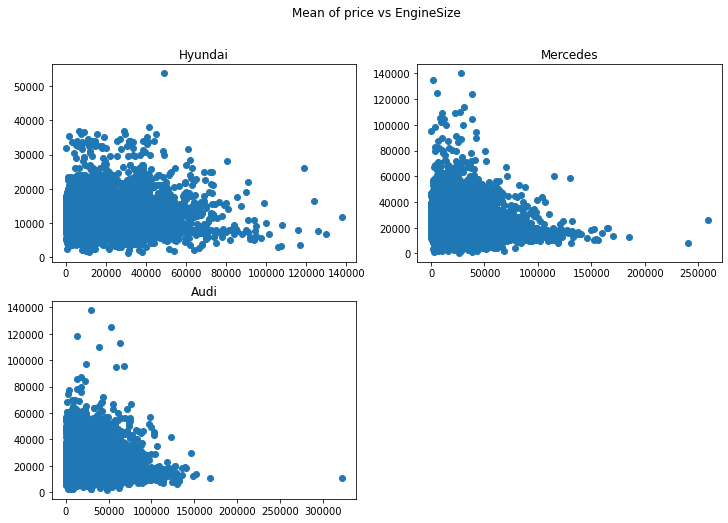

In [70]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
fig.suptitle('Mean of price vs EngineSize')

axs[0, 0].scatter( x = hu.mileage.unique(), y = hu.groupby('mileage')['price'].mean())
axs[0, 1].scatter( x = me.mileage.unique(), y = me.groupby('mileage')['price'].mean())
axs[1, 0].scatter( x = au.mileage.unique(), y = au.groupby('mileage')['price'].mean())
fig.delaxes(axs[1][1])

#set title axs
axs[0, 0].set_title('Hyundai') 
axs[0, 1].set_title('Mercedes') 
axs[1, 0].set_title('Audi') 

**Nhận xét:** *Số dặm xe đã đi càng thấp thì giá xe càng đắt.(hiển nhiên :v)*

In [71]:
df[df['mileage'] < 10]['brand'].value_counts()

mercedes    49
hyundai     12
audi         5
Name: brand, dtype: int64

In [72]:
df[df['mileage'] < 10]

model  year  price transmission  ...  tax   mpg  engineSize     brand
2865    a class  2019  23980    Semi-Auto  ...  145  65.7         1.5  mercedes
2866    a class  2019  24480    Semi-Auto  ...  145  67.3         1.5  mercedes
2867    a class  2019  23980    Semi-Auto  ...  145  28.5         1.3  mercedes
2871    c class  2020  29980    Semi-Auto  ...  150  46.3         1.5  mercedes
2872   cl class  2019  54980    Semi-Auto  ...  150  33.2         2.0  mercedes
...         ...   ...    ...          ...  ...  ...   ...         ...       ...
26317       i30  2019  27800       Manual  ...  145  34.0         2.0   hyundai
26824    tucson  2019  22750       Manual  ...  145  34.9         1.6   hyundai
27010       i10  2020  12394       Manual  ...  145  56.5         1.0   hyundai
27035  santa fe  2020  37995    Semi-Auto  ...  145  39.2         2.2   hyundai
27039    tucson  2019  18495       Manual  ...  145  34.9         1.6   hyundai

[66 rows x 10 columns]

### 9.Những yếu tố nào khiến cho thuế của 1 chiếc xe lại tăng cao?

Tài liệu tham khảo: 

> Reference:  [What factors affect car tax?](https://www.rac.co.uk/drive/advice/buying-and-selling-guides/car-tax-bands-explained/)

Như bài báo trên có viết, Mức thuế xe dựa trên kích thước động cơ (engineSize), hoặc loại nhiên liệu(fuelType) và carbon dioxide (lượng khí thải CO2), tùy thuộc vào thời điểm chiếc xe được đăng ký lần đầu. Lượng khí thải càng thấp, thuế xe càng giảm

In [73]:
df.corr()

year     price   mileage       tax       mpg  engineSize
year        1.000000  0.523089 -0.761774  0.081041 -0.224869   -0.070641
price       0.523089  1.000000 -0.480809  0.301808 -0.535823    0.619579
mileage    -0.761774 -0.480809  1.000000 -0.163534  0.292966    0.074870
tax         0.081041  0.301808 -0.163534  1.000000 -0.590899    0.351235
mpg        -0.224869 -0.535823  0.292966 -0.590899  1.000000   -0.363007
engineSize -0.070641  0.619579  0.074870  0.351235 -0.363007    1.000000

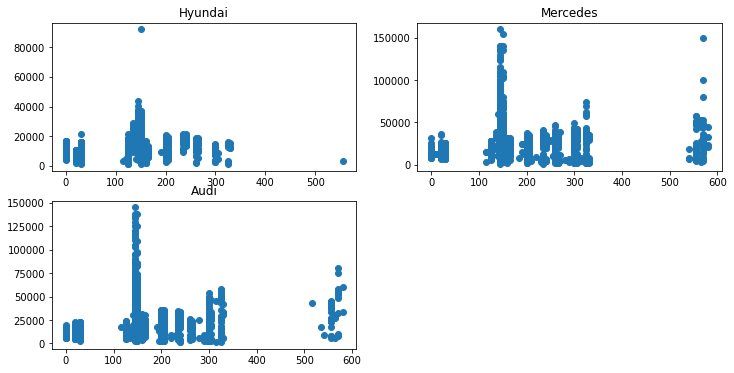

In [74]:

# plt.xlabel('Tax')
# plt.ylabel('Price')
fig, axs = plt.subplots(2, 2, figsize = (12, 6))
# fig.title('Biểu đồ thể hiện mối tương quan giữa thuế và giá của các hãng xe')
axs[0, 0].scatter(hu['tax'], hu['price'])
axs[0, 0].set_title('Hyundai')
axs[0, 1].scatter(me['tax'], me['price'])
axs[0, 1].set_title('Mercedes')
axs[1, 0].scatter(au['tax'], au['price'])
axs[1, 0].set_title('Audi')
fig.delaxes(axs[1][1])


In [75]:
df[['tax', 'price']].corr()

tax     price
tax    1.000000  0.301808
price  0.301808  1.000000

In [76]:
# chart 

fig = px.scatter(df, 
                 x='engineSize', 
                 y='tax',
                color= 'fuelType', 
                title= 'Biểu đồ thể hiện tính tương quan EngineSize vs Tax với cùng loại FuelType')
fig.show()

Nhận xét: 
1. EngineSize có ảnh hưởng đến tax nhưng không quá đáng kể
2. Khi EngineSizee của xe sử dụng cùng 1 loại fuelType chứng minh rằng điều ở trên là đúng

> Reference: **"The amount of car tax you need to pay depends on variables such as CO2 emissions."** - Điều này có nghĩa là lượng khí thải ra càng nhiều thì thuế càng tăng, Nói cách khác, fuelType càng thải nhiều CO2 thì thuế càng cao

In [77]:
# xem qua biểu đồ fuelType và tax
fig = px.scatter(df, 
                  x = 'fuelType',
                  y = 'tax',
                  color ='engineSize')
fig.show()

> [A fuel consumption of 1 litre per 100km corresponds to approximately 26.5g CO2/km for diesel and 23g CO2/km for petrol, depending on the exact composition of the fuel.](https://www.acea.auto/fact/differences-between-diesel-and-petrol/)

Nhận xét: 
1. Ở biểu đồ này ta thấy rõ hơn về Tương quan giữa engineSize và tax
2. EngineSize cần đủ lơn để Tiết kiệm nhiên liệu khi vận hành, đồng nghĩa với việc engineSize càng lớn thì lượng CO2 

<hr>

In [78]:
# xem qua biểu đồ price và tax
fig = px.scatter(df, 
                  x = 'tax',
                  y = 'price',
                  color ='brand',
                 title = 'mối tương quan giữa giá xe và thuế của từng hãng xe')
fig.show()

#Mô Hình Dự Đoán

In [79]:
df.head()

model  year  price transmission  ...  tax   mpg  engineSize     brand
0       slk  2005   5200    Automatic  ...  325  32.1         1.8  mercedes
1   s class  2017  34948    Automatic  ...   20  61.4         2.1  mercedes
2  sl class  2016  49948    Automatic  ...  555  28.0         5.5  mercedes
3   g class  2016  61948    Automatic  ...  325  30.4         4.0  mercedes
4   g class  2016  73948    Automatic  ...  325  30.1         4.0  mercedes

[5 rows x 10 columns]

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28482 entries, 0 to 28481
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         28482 non-null  object 
 1   year          28482 non-null  int64  
 2   price         28482 non-null  int64  
 3   transmission  28482 non-null  object 
 4   mileage       28482 non-null  int64  
 5   fuelType      28482 non-null  object 
 6   tax           28482 non-null  int64  
 7   mpg           28482 non-null  float64
 8   engineSize    28482 non-null  float64
 9   brand         28482 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 2.2+ MB


##1. Random split

In [81]:
X = df.copy()
y = X.pop('price')

In [82]:
# Tách train, test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [83]:
df['model'].nunique()

65

In [84]:
lb_encoder = LabelEncoder()
OH_encoder = OneHotEncoder(sparse=False, drop='first')

In [85]:
lb_encoder.fit(df['model'])
X_train['model'] = lb_encoder.transform(X_train['model'])
X_test['model'] = lb_encoder.transform(X_test['model'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [86]:
X_train.head()

model  year transmission  mileage  ...  tax   mpg  engineSize     brand
15510     39  2015    Semi-Auto    41000  ...  200  47.1         2.0      audi
2897       0  2017    Automatic    32396  ...   20  68.9         2.1  mercedes
23884     61  2019       Manual    11915  ...  150  34.9         1.6   hyundai
22191     38  2015       Manual    71960  ...  125  60.1         2.0      audi
725       12  2016    Semi-Auto    36538  ...   30  65.7         1.6  mercedes

[5 rows x 9 columns]

In [87]:
cat_cols = ['transmission', 'fuelType', 'brand']
OH_encoder.fit(df[cat_cols])

cat_X_train = pd.DataFrame(OH_encoder.transform(X_train[cat_cols]))
cat_X_test = pd.DataFrame(OH_encoder.transform(X_test[cat_cols]))
cat_X_train.index = X_train.index
cat_X_test.index = X_test.index

# Sau khi encode, ta sẽ drop các features gốc và concat lại thành df hoàn chỉnh
num_X_train = X_train.drop(cat_cols, axis=1)
OH_X_train = pd.concat([num_X_train, cat_X_train], axis=1)
num_X_test = X_test.drop(cat_cols, axis=1)
OH_X_test = pd.concat([num_X_test, cat_X_test], axis=1)

In [88]:
num_X_train.head()

model  year  mileage  tax   mpg  engineSize
15510     39  2015    41000  200  47.1         2.0
2897       0  2017    32396   20  68.9         2.1
23884     61  2019    11915  150  34.9         1.6
22191     38  2015    71960  125  60.1         2.0
725       12  2016    36538   30  65.7         1.6

In [89]:
# Baseline model

baseline = RandomForestRegressor(random_state=42)
baseline.fit(OH_X_train, y_train)

y_pred = baseline.predict(OH_X_test)
baseline_score = mean_squared_error(y_test, y_pred, squared=False)
print('Baseline Score: {}'.format(baseline_score))

Baseline Score: 2284.5950678948375


##2. Stratify split

In [90]:
X_stratify = df.copy()
y = X_stratify.pop('price')

In [91]:
X_stratify['rate_price'] = pd.cut(
    y, 4, 
    labels=['Low', 'Medium', 'Lower High', 'High'],
    # ordered=False,
)

In [92]:
X_stratify.head()

model  year transmission  mileage  ...   mpg  engineSize     brand  rate_price
0       slk  2005    Automatic    63000  ...  32.1         1.8  mercedes         Low
1   s class  2017    Automatic    27000  ...  61.4         2.1  mercedes         Low
2  sl class  2016    Automatic     6200  ...  28.0         5.5  mercedes      Medium
3   g class  2016    Automatic    16000  ...  30.4         4.0  mercedes      Medium
4   g class  2016    Automatic     4000  ...  30.1         4.0  mercedes      Medium

[5 rows x 10 columns]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(
    X_stratify, y,
    stratify=X_stratify['rate_price'],
    test_size=0.1,
    random_state=42
)

In [94]:
X_train.head()

model  year transmission  ...  engineSize     brand  rate_price
25683        i30  2020       Manual  ...         2.0   hyundai         Low
385      a class  2017    Semi-Auto  ...         1.6  mercedes         Low
18540         a5  2019    Semi-Auto  ...         2.0      audi         Low
7601     c class  2019    Semi-Auto  ...         2.0  mercedes         Low
3291   glc class  2019    Semi-Auto  ...         2.0  mercedes         Low

[5 rows x 10 columns]

In [95]:
lb_encoder = LabelEncoder()
OH_encoder = OneHotEncoder(sparse=False, drop='first')

# Do số lượng model xe quá nhiều, nếu dùng cách encode OH,
# sẽ không hiệu quả, do đó ta sẽ label encode
lb_encoder.fit(df['model'])
X_train['model'] = lb_encoder.transform(X_train['model'])
X_test['model'] = lb_encoder.transform(X_test['model'])

# Số giá trị của mỗi features là 3, 4, 3. Sau khi encode sẽ thêm 10 features,
# do có options drop='first', số features thêm sẽ là 7.
cat_cols = ['transmission', 'fuelType', 'brand']
OH_encoder.fit(df[cat_cols])

# Vì OH encoder sẽ drop index, ta phải thêm lại index vào chúng
cat_X_train = pd.DataFrame(OH_encoder.transform(X_train[cat_cols]))
cat_X_test = pd.DataFrame(OH_encoder.transform(X_test[cat_cols]))
cat_X_train.index = X_train.index
cat_X_test.index = X_test.index

# Sau khi encode, ta sẽ drop các features gốc và concat lại thành df hoàn chỉnh
num_X_train = X_train.drop(cat_cols, axis=1)
OH_X_train = pd.concat([num_X_train, cat_X_train], axis=1)
num_X_test = X_test.drop(cat_cols, axis=1)
OH_X_test = pd.concat([num_X_test, cat_X_test], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [96]:
for data in [OH_X_train, OH_X_test]:
    data.drop('rate_price', axis=1, inplace=True)

In [97]:
stratify_model = RandomForestRegressor(random_state=42)
stratify_model.fit(OH_X_train, y_train)

pred_y = stratify_model.predict(OH_X_test)
stratify_score = mean_squared_error(y_test, pred_y, squared=False)
print('Stratify Score: {}'.format(stratify_score))

Stratify Score: 2099.782682991197


In [98]:
def diff(old_model, new_model):
    diff_error = abs(old_model - new_model) / old_model * 100
    if old_model > new_model:
        print('Diff Error: - {} %'.format(diff_error))
    else:
        print('Diff Error: + {} %'.format(diff_error))

In [99]:
diff(baseline_score, stratify_score)

Diff Error: - 8.089502927708663 %


##3. Model Drop Outliners

In [100]:
train_fe = pd.concat([OH_X_train, y_train], axis=1)
for col in ['mileage', 'tax', 'mpg']:
    upper_lim = train_fe[col].quantile(0.95)
    lower_lim = train_fe[col].quantile(0.05)

    train_fe = train_fe[(train_fe[col] < upper_lim) & (train_fe[col] > lower_lim)]

train_X_fe = train_fe.copy()
train_y_fe = train_X_fe.pop('price')

model_fe = RandomForestRegressor(random_state=42)
model_fe.fit(train_X_fe, train_y_fe)

pred_y = model_fe.predict(OH_X_test)
drop_extreme_score = mean_squared_error(y_test, pred_y, squared=False)
print('Drop extreme values Score: {}'.format(drop_extreme_score))

Drop extreme values Score: 4885.388675957061


In [101]:
diff(baseline_score, drop_extreme_score)

Diff Error: + 113.84046322304069 %


##4. Chọn features

In [102]:
!pip install eli5

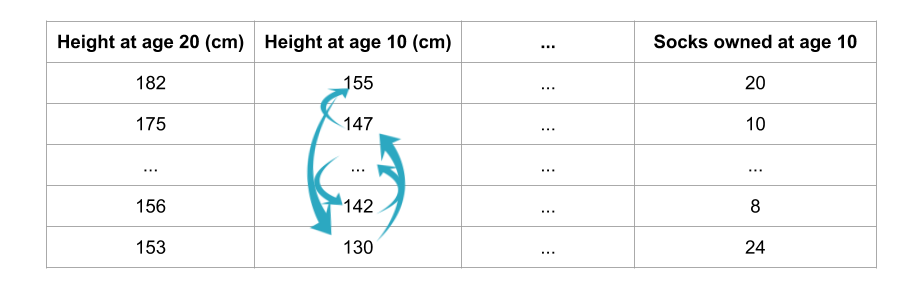

In [ ]:
OH_X_test.columns = OH_X_test.columns.astype(str)

perm = PermutationImportance(stratify_model, random_state=42).fit(OH_X_test, y_test)
eli5.show_weights(perm, feature_names = OH_X_test.columns.tolist())

In [ ]:
OH_X_train_drop = OH_X_train.drop([3, 4, 1], axis=1)
OH_X_test_drop = OH_X_test.drop(['3', '4', '1'], axis=1)

In [ ]:
OH_X_train_drop

In [ ]:
model_drop = RandomForestRegressor(random_state=42)
model_drop.fit(OH_X_train_drop, y_train)

pred_y = model_drop.predict(OH_X_test_drop)

print('Model Drop Features Score: {}'.format(mean_squared_error(y_test, pred_y, squared=False)))

In [ ]:
diff(baseline_score, mean_squared_error(y_test, pred_y, squared=False))

##5. Tune Model Hyperparameters

In [ ]:
# Dùng RandomizedSearchCV để tìm params tốt nhất

n_estimators = [10, 20, 50, 100, 200, 500, 1000]
max_features = ['auto', 'sqrt']
max_depth = [None, 2, 5, 10, 20, 30]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# # Việc chạy RandomizedSearchCV rất lâu, nên mình sẽ lấy luôn kết quả
# # đã chạy từ trước

# model = RandomForestRegressor(random_state=42)
# model_random = RandomizedSearchCV(estimator=model,
#                                param_distributions=random_grid,
#                                n_iter=100, cv=5, verbose=2,
#                                scoring='neg_root_mean_squared_error',
#                                random_state=42, n_jobs=-1)
# model_random.fit(OH_X_train_drop, y_train)

In [ ]:
# model_random.best_params_

In [ ]:
model_best_param = RandomForestRegressor(bootstrap=False,
                            max_depth=20,
                            max_features='sqrt',
                            min_samples_leaf=2,
                            min_samples_split=2,
                            n_estimators=200,
                            random_state=42)

model_best_param.fit(OH_X_train_drop, y_train)

pred_y = model_best_param.predict(OH_X_test_drop)
model_best_param_score = mean_squared_error(y_test, pred_y, squared=False)

print('Model Best params Score: {}'.format(model_best_param_score))

In [ ]:
diff(baseline_score, model_best_param_score)

##6. Test

In [ ]:
final_model = model_drop
y_pred = final_model.predict(OH_X_test_drop)
print('Căn bậc 2 Sai số toàn phương trung bình: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))

In [ ]:
pred = pd.concat([X_test, y_test], axis=1)
pred['Predict'] = np.around(y_pred)
pred['% Diff'] = abs(y_pred - y_test) / y_test * 100
pred['model'] = lb_encoder.inverse_transform(pred['model'])
pred.head()

In [ ]:
print('Sai số cao nhất: {} %'.format(pred['% Diff'].max()))
print('Sai số thấp nhất: {} %'.format(pred['% Diff'].min()))

In [ ]:
large_error = pred[pred['% Diff'] > 20]
large_error.sort_values('% Diff', ascending=False)[:10]

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=pred, x='% Diff')
plt.show()

In [ ]:
print(final_model.score(OH_X_train_drop, y_train))
print(final_model.score(OH_X_test_drop, y_test))

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=pred, x='% Diff')
plt.xlim([-1, 20])
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred)
x = np.linspace(0, 140000)
sns.lineplot(x=x, y=x, c='r')

plt.xlabel('Giá thật')
plt.ylabel('Giá dự đoán')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred)
x=np.linspace(1, 140000)
sns.lineplot(x=x, y=x, c='r')
plt.xlabel('Giá thật')
plt.ylabel('Giá dự đoán')
plt.xlim([0, 60000])
plt.ylim([0, 60000])
plt.show()



> Điểm dữ liệu nào nằm trên red line có nghĩa là giá dự đoán cao hơn giá trị thật, ngược lại tức là giá dự đoán thấp hơn giá trị thật.



In [ ]:
test = pd.DataFrame({'model': ['s class'], 'year': [2017], 'mileage': [27000], 'tax': [20], 'mpg': [61.4], 'engineSize': [2.1],
                    'transmission': ['Automatic'], 'fuelType': ['Hybrid'], 'brand': ['mercedes']})

In [ ]:
test['model'] = lb_encoder.transform(test['model'])
cat_cols = ['transmission', 'fuelType', 'brand']

cat_test = pd.DataFrame(OH_encoder.transform(test[cat_cols]))
cat_test.index = test.index

num_test = test.drop(cat_cols, axis=1)
OH_test = pd.concat([num_test, cat_test], axis=1)
OH_test.drop([3, 4, 1], axis=1, inplace=True)
predict = final_model.predict(OH_test)
print('Giá dự đoán: {}'.format(predict))

In [ ]:
y_train_pred = final_model.predict(OH_X_train_drop)
print('RMSE trên trainset:', mean_squared_error(y_train, y_train_pred, squared=False))

In [ ]:
print('RMSE trên testset:', mean_squared_error(y_test, y_pred, squared=False))

In [ ]:
pred.head()

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(pred.corr(), annot=True)

In [ ]:
err_mean_year = pred.groupby('year')['% Diff'].mean()
err_mean_year

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=err_mean_year.index, y=err_mean_year.values)
plt.ylabel('Mean Diff')
plt.xlabel('Year')
plt.show()

In [ ]:
year_train = OH_X_train['year'].value_counts()
year_test = OH_X_test['year'].value_counts()

year_train_df = pd.DataFrame(
    {'year': year_train.index,
     'count train': year_train.values,
})

year_test_df = pd.DataFrame(
    {'year': year_test.index,
     'count test': year_test.values,
})

In [ ]:
year_test_df.merge(year_train_df, on='year')

tập dữ liệu này bị thiếu dữ liệu

In [ ]:
plt.figure(figsize=(18, 15))
sns.countplot(data=df, y='model', order=df['model'].value_counts(ascending=False).index)

In [ ]:
df.head()

In [ ]:
X = df.copy()
y = X.pop('price')

In [ ]:
X['rate_price'] = pd.cut(
    y, 4, 
    labels=['Low', 'Medium', 'Lower High', 'High'],
    ordered=False,
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=X['rate_price'],
    random_state=42
)

In [ ]:
for data in [X_train, X_test]:
    data.drop('rate_price', axis=1, inplace=True)

In [ ]:
cat_cols = X_train.select_dtypes('object').columns
num_cols = X_train.select_dtypes('number').columns

In [ ]:
def hist_plot(col):
    sns.histplot(data=df, x=col)
    plt.show()

In [ ]:
df['model'].value_counts(ascending=False).index

In [ ]:
plt.figure(figsize=(18, 15))
sns.countplot(data=df, y='model', order=df['model'].value_counts(ascending=False).index)

In [ ]:
model_price = df.groupby('model')['price'].mean()

In [ ]:
plt.figure(figsize=(18, 15))
sns.barplot(y=model_price.index, x=model_price.values, order=df['model'].value_counts(ascending=False).index)